## Stock Market Prediction
In this work, we will try to predict whether the stock price will go up or down the next day based on the previous day's stock price. We will use the S&P 500 index data, which is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States.


In [19]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import git

In [2]:
repo_path = git.Repo('.', search_parent_directories=True).working_tree_dir
data_path = repo_path + '/data/sp500.csv'

In [3]:
# load the dataset
df = pd.read_csv(data_path)

In [4]:
print(f'Shape of the dataset: {df.shape}')
df.head()

Shape of the dataset: (18292, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1950-01-03,16.66,16.66,16.66,16.66,1260000,0,0
1,1950-01-04,16.85,16.85,16.85,16.85,1890000,0,0
2,1950-01-05,16.93,16.93,16.93,16.93,2550000,0,0
3,1950-01-06,16.98,16.98,16.98,16.98,2010000,0,0
4,1950-01-09,17.08,17.08,17.08,17.08,2520000,0,0


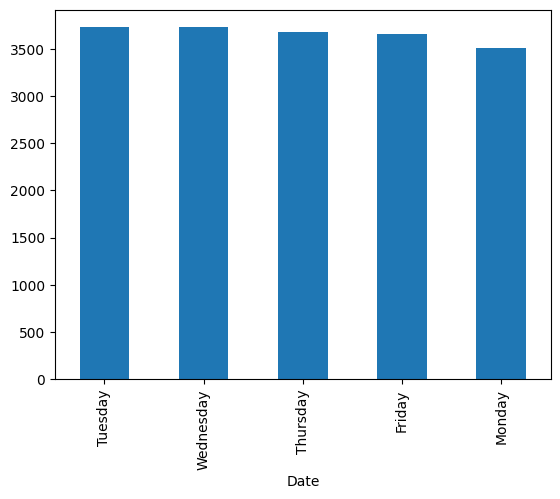

In [5]:
# convert to name of the days
pd.to_datetime(df['Date']).dt.day_name().value_counts().plot(kind='bar');

So, only the trading days are considered.

Let's plot the Close price...

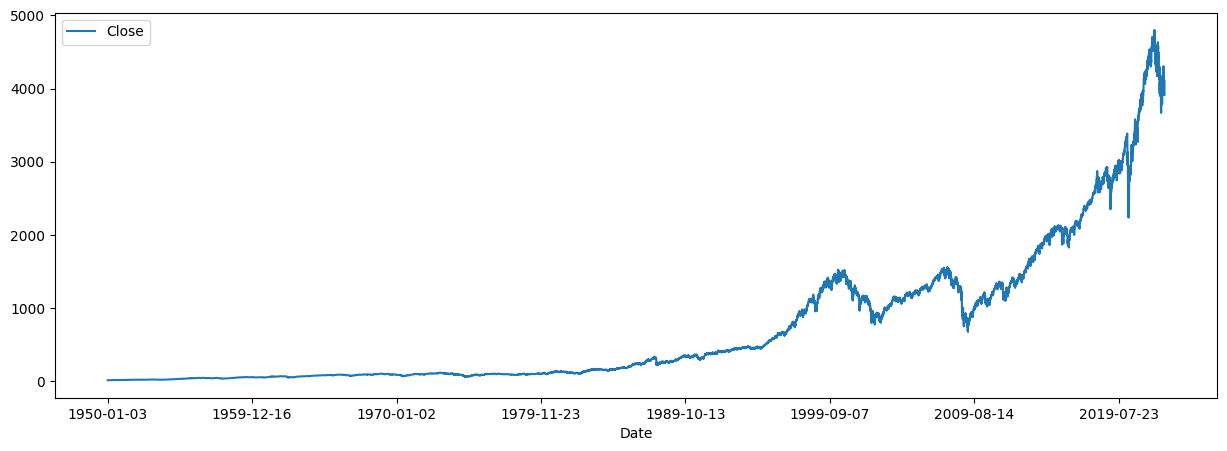

In [6]:
df.plot(kind='line', x='Date', y='Close', figsize=(15, 5));

### Data Cleaning and Preprocessing

We will get rid of the "Dividents" and "Stock Splits" columns, as they are not relevant to our analysis.

In [7]:
del df['Dividends'], df['Stock Splits']

In [8]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,1260000
1,1950-01-04,16.85,16.85,16.85,16.85,1890000
2,1950-01-05,16.93,16.93,16.93,16.93,2550000
3,1950-01-06,16.98,16.98,16.98,16.98,2010000
4,1950-01-09,17.08,17.08,17.08,17.08,2520000


We compare the "Close" price of the current day with the "Close" price of the next day. If the price is higher, we assign a 1 to the "Target" column, otherwise we assign a 0.

In [9]:
# set the target variable, i.e., will the price increase or decrease the next day
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.head()

,Date,Open,High,Low,Close,Volume,Target
0,1950-01-03,16.66,16.66,16.66,16.66,1260000,1
1,1950-01-04,16.85,16.85,16.85,16.85,1890000,1
2,1950-01-05,16.93,16.93,16.93,16.93,2550000,1
3,1950-01-06,16.98,16.98,16.98,16.98,2010000,1
4,1950-01-09,17.08,17.08,17.08,17.08,2520000,0


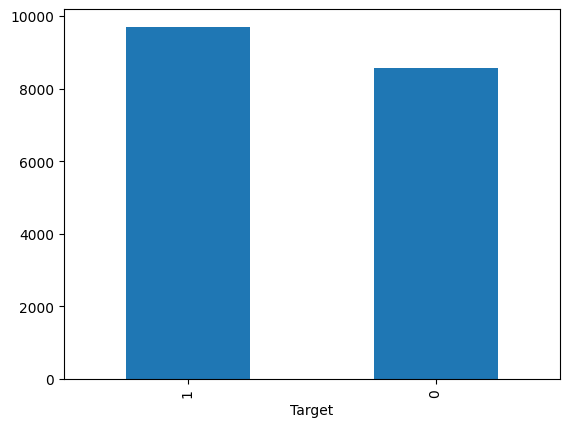

In [10]:
# class distribution
df['Target'].value_counts().plot(kind='bar');

The classes are pretty balanced!

In [11]:
# Let's create features from the date column
df['day'] = pd.to_datetime(df['Date']).dt.day
df['month'] = pd.to_datetime(df['Date']).dt.month
df['year'] = pd.to_datetime(df['Date']).dt.year

In [12]:
df.head()

,Date,Open,High,Low,Close,Volume,Target,day,month,year
0,1950-01-03,16.66,16.66,16.66,16.66,1260000,1,3,1,1950
1,1950-01-04,16.85,16.85,16.85,16.85,1890000,1,4,1,1950
2,1950-01-05,16.93,16.93,16.93,16.93,2550000,1,5,1,1950
3,1950-01-06,16.98,16.98,16.98,16.98,2010000,1,6,1,1950
4,1950-01-09,17.08,17.08,17.08,17.08,2520000,0,9,1,1950


The nature of the stock market changes over time, so we will use the data from 1995 to the end. 

For train, test split, we can't use any randomnization, because the data is time series. So, we will use the first 80% of the data for training and the last 20% for testing.

### Train, Test Split

In [13]:
# train test split
X = df.drop(['Date', 'Target'], axis=1).values
y = df['Target'].values

X_train, y_train = X[:int(X.shape[0] * 0.8)], y[:int(y.shape[0] * 0.8)]
X_test, y_test = X[int(X.shape[0] * 0.8):], y[int(y.shape[0] * 0.8):]

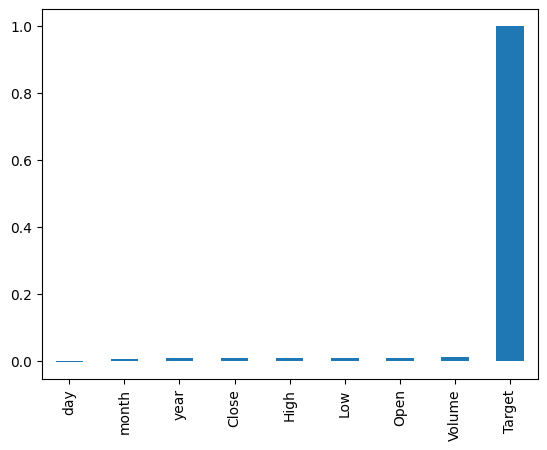

In [14]:
# how are the features correlated with the target variable?
df.drop(['Date'], axis=1).corr()['Target'].sort_values().plot(kind='bar');

Features are not very strongly correlated with the target. That's fine for a baseline model, though.

### Train and Test the Model

In [30]:
# Let's train a simple XGBoost model
model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    random_state=42,
    device='cpu'
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [31]:
# make predictions for test data
y_pred = model.predict(X_test)

# evaluate predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.64      0.53      1666
           1       0.55      0.37      0.44      1993

    accuracy                           0.49      3659
   macro avg       0.50      0.50      0.49      3659
weighted avg       0.51      0.49      0.48      3659



More about precision and recall [here](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall).